# Kidney Stone Detection using CNN

## Importing Libraries

In [1]:
import os 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
import numpy as np

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import random

## Preparing Training Data

In [2]:
# Set data directory for kidney stone detection
data_dir = './CT_images/Train'

# Define class labels for kidney stone detection
class_labels = ['Normal', 'Stone']

In [3]:
# Create file paths and labels lists
filepaths = []
labels = []

for label in class_labels:
    class_dir = os.path.join(data_dir, label)
    if os.path.exists(class_dir):
        for file in os.listdir(class_dir):
            if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
                filepaths.append(os.path.join(class_dir, file))
                labels.append(label)
    else:
        print(f"Directory {class_dir} does not exist")

In [4]:
# Create DataFrame for kidney stone data
kidney_stone_df = pd.DataFrame({
    'filepaths': filepaths,
    'labels': labels
})

In [5]:
# Shuffle the dataset
kidney_stone_df = kidney_stone_df.sample(frac=1).reset_index(drop=True)

In [6]:
# Display first few rows
print(f"Total samples: {len(kidney_stone_df)}")
print(f"Class distribution:")
print(kidney_stone_df['labels'].value_counts())
kidney_stone_df.head()

Total samples: 5258
Class distribution:
labels
Normal    4117
Stone     1141
Name: count, dtype: int64


,filepaths,labels
0,./CT_images/Train\Stone\Stone- (774).jpg,Stone
1,./CT_images/Train\Stone\Stone- (979).jpg,Stone
2,./CT_images/Train\Normal\Normal- (1686).jpg,Normal
3,./CT_images/Train\Normal\Normal- (3742).jpg,Normal
4,./CT_images/Train\Normal\Normal- (850).jpg,Normal


## Data Visualization

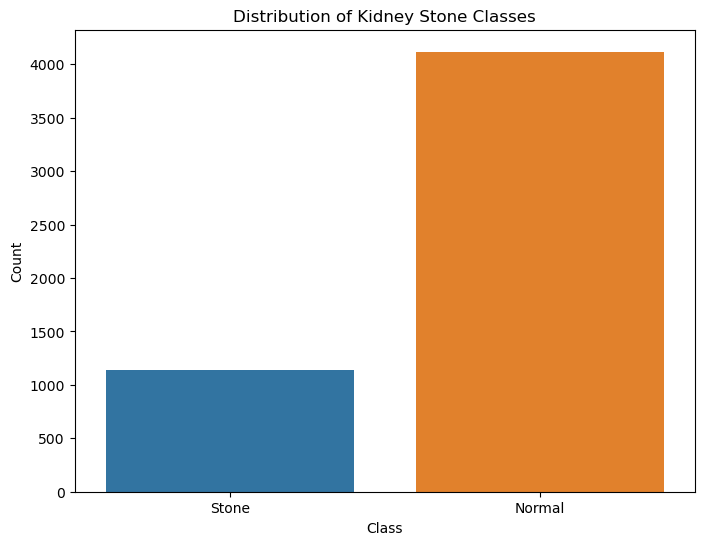

In [7]:
# Plot class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=kidney_stone_df, x='labels')
plt.title('Distribution of Kidney Stone Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

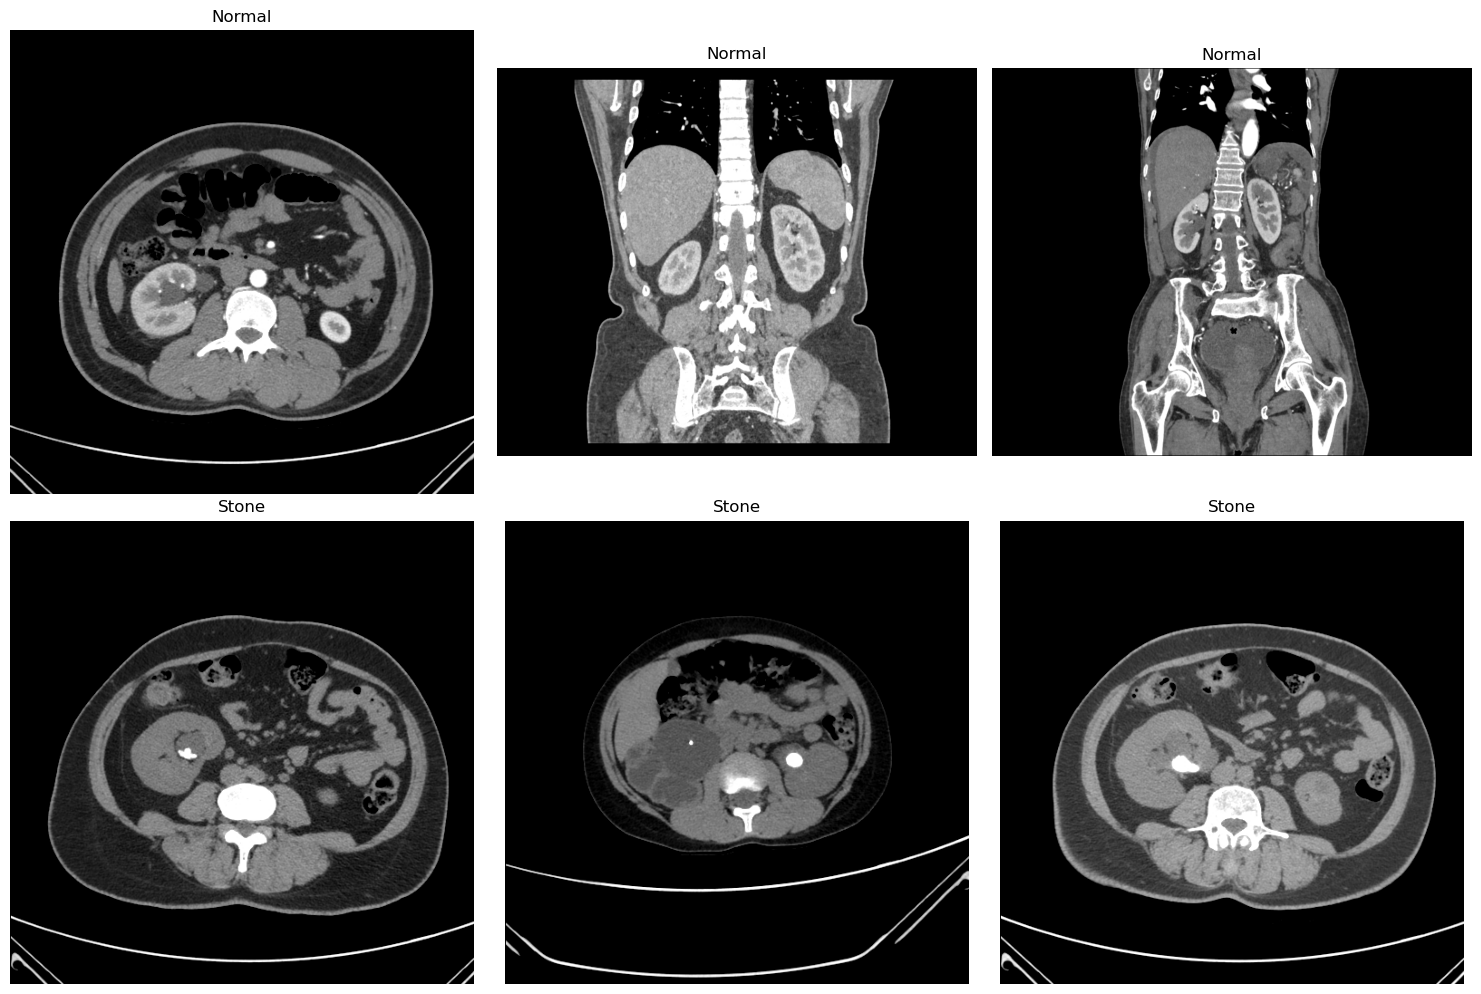

In [8]:
# Display sample images from each class
def show_sample_images(df, n_samples=3):
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 10))
    
    for i, label in enumerate(class_labels):
        class_samples = df[df['labels'] == label].sample(n_samples)
        
        for j, (_, row) in enumerate(class_samples.iterrows()):
            img_path = row['filepaths']
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[i, j].imshow(img)
            axes[i, j].set_title(f'{label}')
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

show_sample_images(kidney_stone_df)

## Data Splitting

In [9]:
# Split data into train, validation, and test sets
train_df, temp_df = train_test_split(kidney_stone_df, test_size=0.3, random_state=42, stratify=kidney_stone_df['labels'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['labels'])

print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

print("\nTraining set distribution:")
print(train_df['labels'].value_counts())
print("\nValidation set distribution:")
print(val_df['labels'].value_counts())
print("\nTest set distribution:")
print(test_df['labels'].value_counts())

Training set: 3680 samples
Validation set: 789 samples
Test set: 789 samples

Training set distribution:
labels
Normal    2881
Stone      799
Name: count, dtype: int64

Validation set distribution:
labels
Normal    618
Stone     171
Name: count, dtype: int64

Test set distribution:
labels
Normal    618
Stone     171
Name: count, dtype: int64


## Data Generators with Augmentation

In [10]:
# Define image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Found 3680 validated image filenames belonging to 2 classes.
Found 789 validated image filenames belonging to 2 classes.
Found 789 validated image filenames belonging to 2 classes.


## Building CNN Model

In [11]:
# Build CNN model for kidney stone detection
model = Sequential()

# First convolutional block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth convolutional block
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer for binary classification
model.add(Dense(2, activation='softmax'))  # 2 classes: Normal and Stone

# Display model summary
model.summary()

c:\Users\Admin\anaconda3\anoconda 3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,400,130 (74.01 MB)

 Trainable params: 19,397,634 (74.00 MB)

 Non-trainable params: 2,496 (9.75 KB)

## Model Compilation

In [12]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")

Model compiled successfully!


## Callbacks

In [13]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

## Model Training

In [14]:
# Train the model
EPOCHS = 50

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks,
    verbose=1
)

c:\Users\Admin\anaconda3\anoconda 3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.6615 - loss: 0.9331 - val_accuracy: 0.2167 - val_loss: 12.0313 - learning_rate: 0.0010
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.8228 - loss: 0.4461 - val_accuracy: 0.2167 - val_loss: 16.2488 - learning_rate: 0.0010
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.8954 - loss: 0.2692 - val_accuracy: 0.2167 - val_loss: 16.4911 - learning_rate: 0.0010
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9024 - loss: 0.2529 - val_accuracy: 0.7858 - val_loss: 0.6087 - learning_rate: 0.0010
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9154 - loss: 0.2215 - val_accuracy: 0.4056 - val_loss: 2.6379 - learning_rate: 0.0010
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.8962 - loss: 0.2695 - val_accuracy: 0.9189 - val_loss: 0.1862 - learning_rate: 0.0010
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9442 - loss:

## Training History Visualization

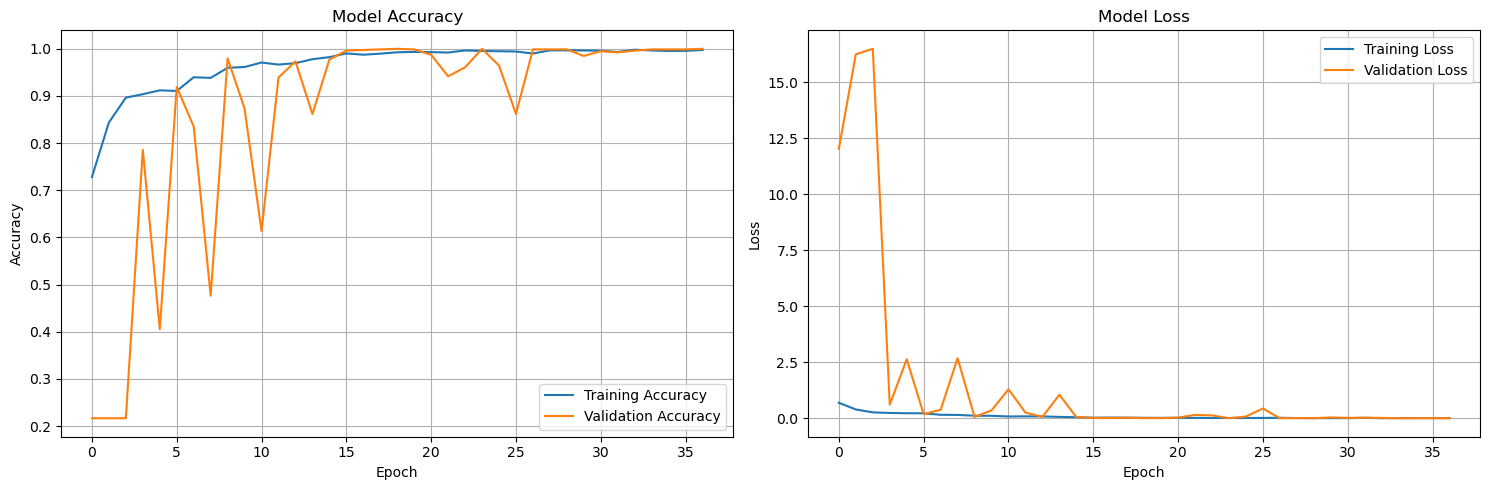

In [15]:
# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

## Model Evaluation

In [16]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 773ms/step - accuracy: 0.9944 - loss: 0.0074

Test Accuracy: 0.9924
Test Loss: 0.0110


In [17]:
# Make predictions on test set
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels_list = list(test_generator.class_indices.keys())

print(f"Class labels: {class_labels_list}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step
Class labels: ['Normal', 'Stone']


## Confusion Matrix and Classification Report

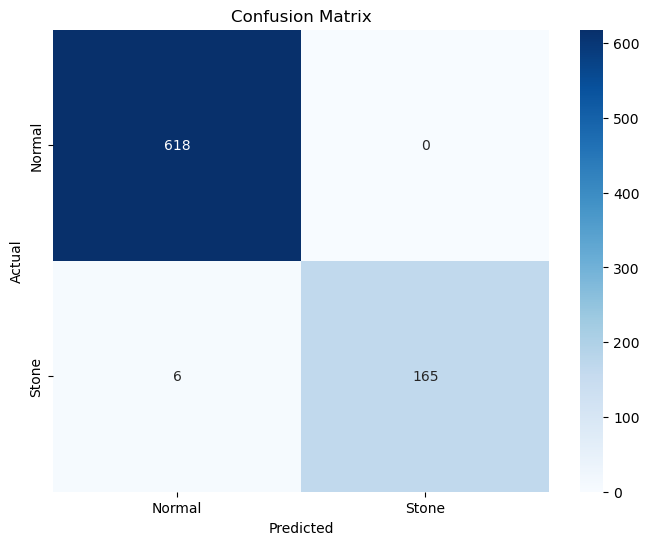


Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00       618
       Stone       1.00      0.96      0.98       171

    accuracy                           0.99       789
   macro avg       1.00      0.98      0.99       789
weighted avg       0.99      0.99      0.99       789



In [18]:
# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels_list, 
            yticklabels=class_labels_list)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels_list))

## Save Model

In [19]:
# Save the trained model
model.save('kidney_stone_detection_cnn_model.h5')
print("Model saved as 'kidney_stone_detection_cnn_model.h5'")

Model saved as 'kidney_stone_detection_cnn_model.h5'


## Prediction Function for New Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Sample prediction:
Image: ./CT_images/Train\Normal\Normal- (2405).jpg
Predicted class: Normal
Confidence: 1.0000
Actual class: Normal


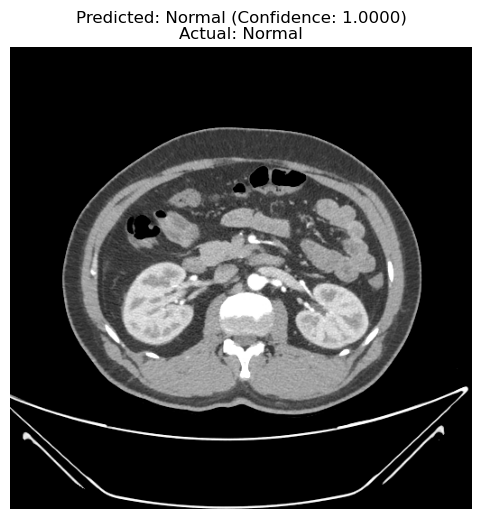

In [20]:
def predict_kidney_stone(image_path, model):
    """
    Predict whether a CT scan shows kidney stone or normal kidney
    
    Args:
        image_path: Path to the CT scan image
        model: Trained CNN model
    
    Returns:
        prediction: Class prediction and confidence
    """
    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # Make prediction
    prediction = model.predict(img)
    predicted_class_idx = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class_idx]
    
    # Map to class name
    class_names = ['Normal', 'Stone']
    predicted_class = class_names[predicted_class_idx]
    
    return predicted_class, confidence

# Test the prediction function with a sample image
if len(test_df) > 0:
    sample_image_path = test_df.iloc[0]['filepaths']
    predicted_class, confidence = predict_kidney_stone(sample_image_path, model)
    
    print(f"Sample prediction:")
    print(f"Image: {sample_image_path}")
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.4f}")
    print(f"Actual class: {test_df.iloc[0]['labels']}")
    
    # Display the image
    img = cv2.imread(sample_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class} (Confidence: {confidence:.4f})\nActual: {test_df.iloc[0]["labels"]}')
    plt.axis('off')
    plt.show()

## Test Multiple Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


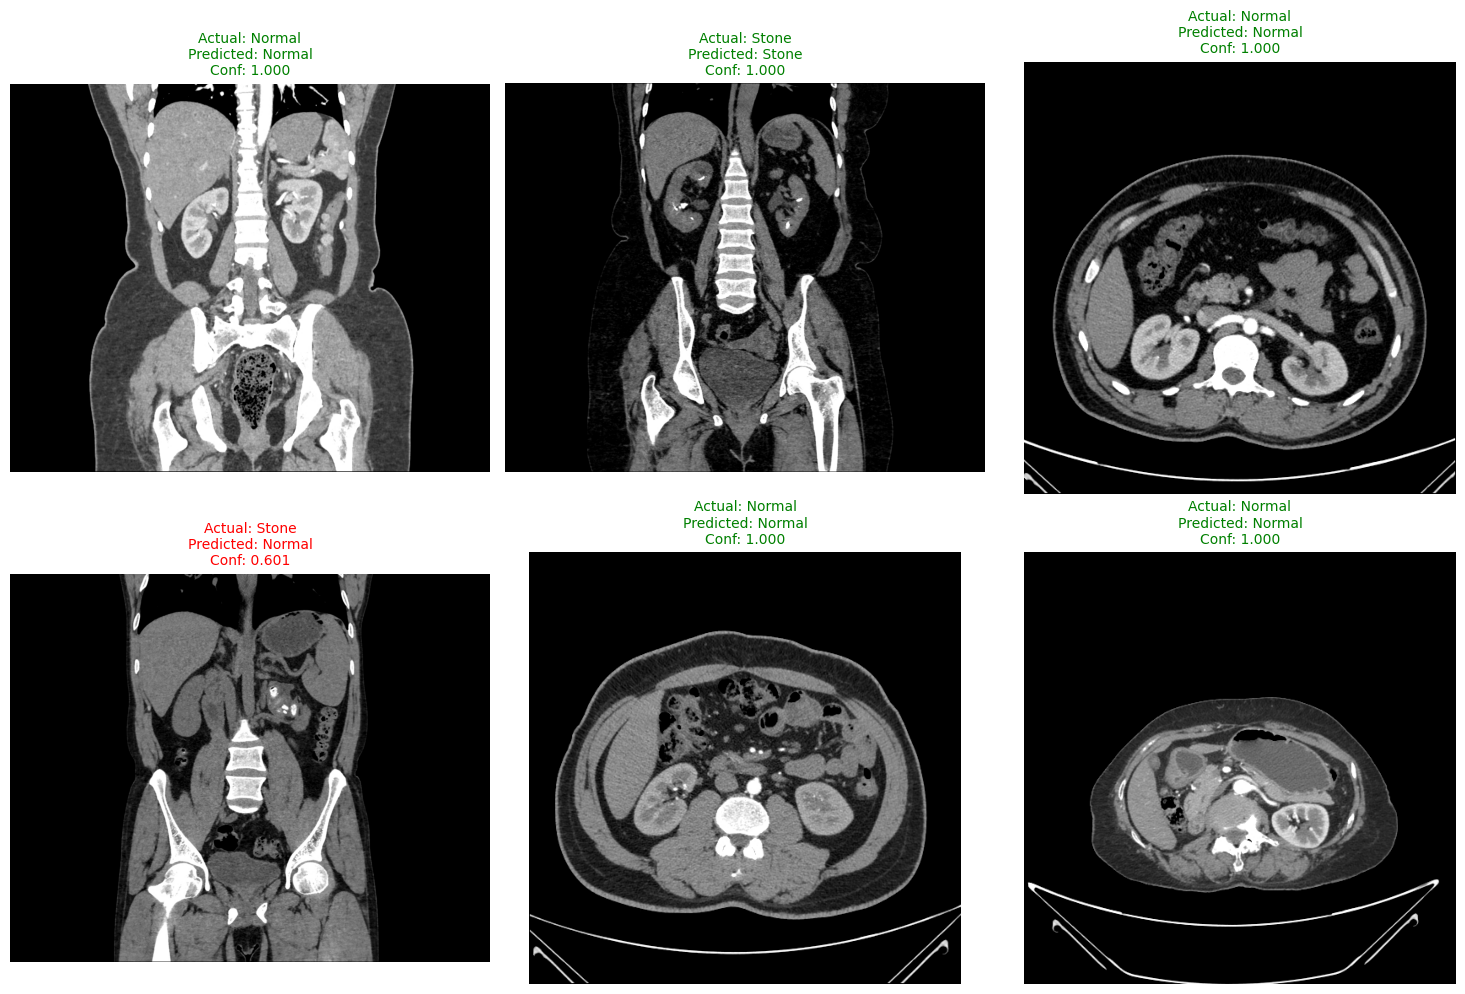

In [21]:
# Test prediction on multiple random images
def test_multiple_predictions(df, model, n_samples=6):
    sample_df = df.sample(n_samples)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, (_, row) in enumerate(sample_df.iterrows()):
        img_path = row['filepaths']
        actual_label = row['labels']
        
        # Make prediction
        predicted_class, confidence = predict_kidney_stone(img_path, model)
        
        # Load and display image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img)
        
        # Set title with prediction results
        color = 'green' if predicted_class == actual_label else 'red'
        axes[i].set_title(f'Actual: {actual_label}\nPredicted: {predicted_class}\nConf: {confidence:.3f}', 
                         color=color, fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

if len(test_df) >= 6:
    test_multiple_predictions(test_df, model)